In [2]:
from torch.backends.mkl import verbose
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries


## Read electricity data

In [4]:
electricity_consumption = pd.read_csv("../dataset/residential_all_zone.csv")
electricity_consumption_upper_north = electricity_consumption.loc[electricity_consumption['Region ID']=="UNI"]
df = electricity_consumption_upper_north.copy()
# Convert 'Period start' to datetime, handling potential errors
df['Period start'] = pd.to_datetime(df['Period start'], format='%d/%m/%Y', errors='coerce')
ts = TimeSeries.from_dataframe(df, time_col="Period start" ,value_cols="Est. Total consumption (GWh)")
# electricity_consumption_upper_north_ts = TimeSeries.from_dataframe(electricity_consumption_upper_north, "Period start")
# print(electricity_consumption_upper_north_ts)

<Axes: xlabel='Period start'>

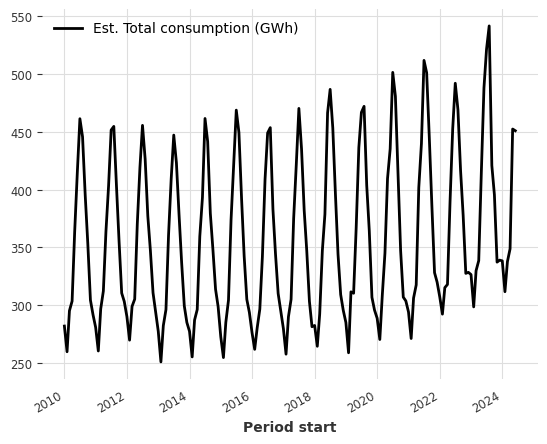

In [5]:
ts.plot()

<Axes: xlabel='Period start'>

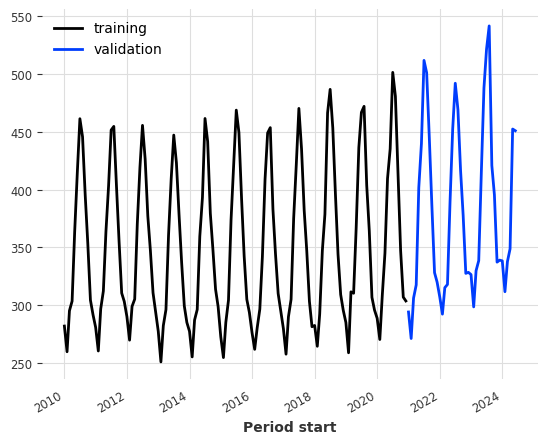

In [6]:
# training and validation split
train, val = ts.split_before(pd.Timestamp('2021-01-01'))
train.plot(label='training')
val.plot(label='validation')

## Preprocessing

In [58]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from sklearn.preprocessing import MinMaxScaler

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape, mae
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

scaler = MinMaxScaler(feature_range=(0, 1))
transformer = Scaler(scaler)
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(ts)

# create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=ts.start_time(), freq=ts.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp('2020-01-01'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model training and testing

In [9]:
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [59]:
model_lstm = RNNModel(
    model="LSTM",
    hidden_dim=35,
    dropout=0.05,
    batch_size=32,
    n_epochs=400,
    optimizer_kwargs={"lr": 1e-2},
    model_name="Electricity_LSTM",
    log_tensorboard=True,
    training_length=40,
    input_chunk_length=32,
    force_reset=True,
    save_checkpoints=True,
)

model_lstm.fit( train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=False)

RNNModel(model=LSTM, hidden_dim=35, n_rnn_layers=1, dropout=0.05, training_length=40, batch_size=32, n_epochs=400, optimizer_kwargs={'lr': 0.01}, model_name=Electricity_LSTM, log_tensorboard=True, input_chunk_length=32, force_reset=True, save_checkpoints=True)

Predicting: |          | 0/? [00:00<?, ?it/s]

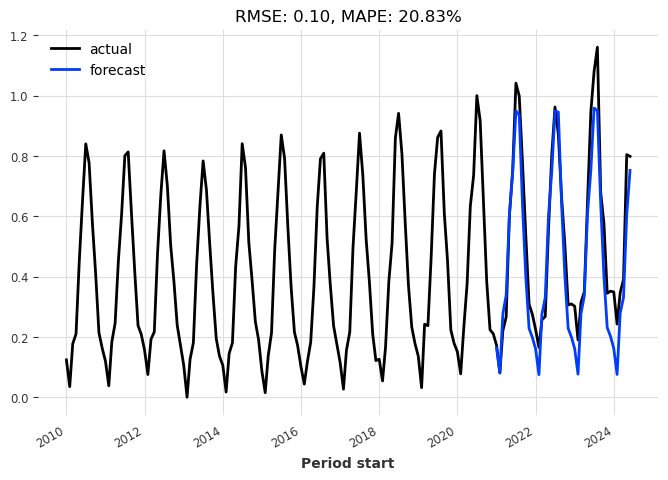

In [62]:
from darts.metrics import rmse
def eval_model(model):
    pred_series = model.predict(n=42, future_covariates=covariates)
    plt.figure(figsize=(8, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("RMSE: {:.2f}, MAPE: {:.2f}%".format(rmse(val_transformed, pred_series), mape(val_transformed, pred_series)))
    plt.legend()
    return pred_series

pred_series_transformed = eval_model(model_lstm)

# Mean Absolute Percentage Error

In [64]:
val_transformed.pd_dataframe()

component,Est. Total consumption (GWh)
Period start,
2021-01-01,0.172382
2021-02-01,0.080858
2021-03-01,0.220478
2021-04-01,0.266054
2021-05-01,0.601850
2021-06-01,0.754546
2021-07-01,1.041391
2021-08-01,0.998559
2021-09-01,0.773856


In [65]:
pred_series_transformed.pd_dataframe()

component,Est. Total consumption (GWh)
Period start,
2021-01-01,0.163479
2021-02-01,0.079976
2021-03-01,0.276715
2021-04-01,0.338313
2021-05-01,0.604461
2021-06-01,0.746781
2021-07-01,0.949538
2021-08-01,0.935506
2021-09-01,0.632977


In [ ]:
# check seasonablity
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05, max_lag=24)